In [342]:
import numpy             as np
import matplotlib.pyplot as plt
import scipy.sparse      as sparse
import scipy.special     as sp
import hylife.utilitis_FEEC.bsplines             as bsp
import hylife.utilitis_FEEC.evaluation           as eva
import hylife.geometry.mappings_analytical       as mapping
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import axes3d, Axes3D
import time
%load_ext jupyternotify

The jupyternotify extension is already loaded. To reload it, use:
  %reload_ext jupyternotify


In [344]:
def Parameters(Nel       = [8,8, 2],              # mesh generation on logical domain
               bc        = [True, True, True],      # boundary conditions (True: periodic, False: else)
               p         = [3, 4, 1],         # spline degrees 
               Nq        = [1, 6, 2],
               Lx        = 4.,
               Ly        = 2.,
               Lz        = 1.,
               kind_map  = 1,
               alpha     =0.05):# number of quadrature points per element


    el_b      = [np.linspace(0., 1., Nel + 1) for Nel in Nel]                      # element boundaries
    delta     = [1/Nel for Nel in Nel]                                            # element sizes
    T         = [bsp.make_knots(el_b, p, bc) for el_b, p, bc in zip(el_b, p, bc)]  # knot vectors (for N functions)
    t         = [T[1:-1] for T in T]                                               # reduced knot vectors (for D function)
    NbaseN    = [Nel + p - bc*p for Nel, p, bc in zip(Nel, p, bc)]                 # number of basis functions (N functions)
    NbaseD    = [NbaseN - (1 - bc) for NbaseN, bc in zip(NbaseN, bc)]              #number of basis functions (D functions)

    if kind_map == 1:               #slab geometry
        args_map = [kind_map, [Lx,Ly,Lz]]
    elif kind_map ==3:
        args_map = kind_map, [Lx,Ly,alpha,Lz]

    print('Parameters update Realized')
    return Nel, bc, p, Nq, el_b, delta, T, t, NbaseN, NbaseD, Lx, Ly, Lz, kind_map, args_map, alpha     

In [345]:
def Projectors_ini():
    global T, p, bc, Nq
    import hylife.utilitis_FEEC.projectors_global    as projectors_global
    import hylife.utilitis_FEEC.derivatives          as derivatives

    proj_glob = projectors_global.projectors_3d(T, p, bc,Nq)

    proj_glob.assemble_V3()
    proj_glob.assemble_V2()
    proj_glob.assemble_V1()
    der = derivatives.discrete_derivatives(T, p, bc)
    DIV  = der.DIV_3d()
    print('Projectors Initialized')
    return proj_glob, der, DIV

In [346]:
(Nel, bc, p, Nq, el_b, 
 delta, T, t, NbaseN, 
 NbaseD, Lx, Ly, Lz, kind_map,
 args_map, alpha)=Parameters(Nel=[4,4,2])
(proj_glob, der, DIV)=Projectors_ini()

Parameters update Realized
Projectors Initialized


#### Definition of the initialization functions

In [347]:
#rho_ini_phys = lambda x, y, z : (1+0.5*np.sin(2*np.pi*(x/Lx-y/Ly)))
rho_ini_phys = lambda x, y, z : (np.sin(2*np.pi*x/Lx))

In [348]:
vx_ini_phys = lambda x, y, z : 1.
vy_ini_phys = lambda x, y, z : 0. #-0.5
vz_ini_phys = lambda x, y, z : 0.

In [349]:
#pointwise function evaluation
def rho_ini_pw(xi1, xi2, xi3): 
    x = mapping.f(xi1, xi2, xi3, *args_map, 1) #Analytic Mapping to slab Geometry
    y = mapping.f(xi1, xi2, xi3, *args_map, 2)
    z = mapping.f(xi1, xi2, xi3, *args_map, 3)
    rho = rho_ini_phys(x, y, z) * mapping.det_df(xi1, xi2, xi3, *args_map)
    return rho

In [350]:
# input, for projector V3:  three 1d point arrays
def rho_ini(xi1_arr, xi2_arr, xi3_arr):
    n1 = xi1_arr.shape[0]
    n2 = xi2_arr.shape[0]
    n3 = xi3_arr.shape[0]
    rho = np.empty((n1, n2, n3), dtype=float) # Returns numpy array of shape [n1,n2,n3] same fct as np.zeros
    for i1 in range(n1):
        for i2 in range(n2):
            for i3 in range(n3):
                idx = i1, i2, i3
                rho[idx] = rho_ini_pw(xi1_arr[i1], xi2_arr[i2], xi3_arr[i3])
    return rho

In [351]:
#pointwise function evaluation, for velocity as a 1-form
def vk_ini_pw(xi1, xi2, xi3,k):
    x = mapping.f(xi1, xi2, xi3, *args_map, 1)
    y = mapping.f(xi1, xi2, xi3, *args_map, 2)
    z = mapping.f(xi1, xi2, xi3, *args_map, 3)
    #WE should use Transpose
    df_inv_k1 = mapping.df_inv(xi1, xi2, xi3, *args_map, k*10+1)
    df_inv_k2 = mapping.df_inv(xi1, xi2, xi3, *args_map, k*10+2)
    df_inv_k3 = mapping.df_inv(xi1, xi2, xi3, *args_map, k*10+3)
    
    v =(vx_ini_phys(x, y, z) * df_inv_k1 + 
        vy_ini_phys(x, y, z) * df_inv_k2 + 
        vz_ini_phys(x, y, z) * df_inv_k3   )
    
    #df_1k = mapping.df(xi1, xi2, xi3, *args_map, 10+k)
    #df_2k = mapping.df(xi1, xi2, xi3, *args_map, 20+k)
    #df_3k = mapping.df(xi1, xi2, xi3, *args_map, 30+k)
    #
    #v  =(vx_ini_phys(x, y, z) * df_1k + 
    #     vy_ini_phys(x, y, z) * df_2k + 
    #     vz_ini_phys(x, y, z) * df_3k   )
    return v


# input, for projector V1:  two point values and one 1d point array
def v1_ini_PI1(xi1_arr, xi2, xi3):
    n1 = xi1_arr.shape[0]
    v1 = np.empty((n1), dtype=float)
    for i1 in range(n1):
            
        v1[i1] = vk_ini_pw(xi1_arr[i1],xi2,xi3,1)
            
    return v1

def v2_ini_PI1(xi1, xi2_arr, xi3):
    n2 = xi2_arr.shape[0]
    v2 = np.empty((n2), dtype=float)
    for i2 in range(n2):
            
        v2[i2] = vk_ini_pw(xi1,xi2_arr[i2],xi3,2)
            
    return v2

def v3_ini_PI1(xi1, xi2, xi3_arr):
    n3 = xi3_arr.shape[0]
    v3 = np.empty((n3), dtype=float)
    for i3 in range(n3):
            
        v3[i3] = vk_ini_pw(xi1,xi2,xi3_arr[i3],3)
            
    return v3


# input, for projector V2:  one point values and two 1d point array
def v1_ini_PI2(xi1, xi2_arr, xi3_arr):
    n2 = xi2_arr.shape[0]
    n3 = xi3_arr.shape[0]
    v1 = np.empty((n2,n3), dtype=float)
    for i2 in range(n2):
        for i3 in range(n3):
            
            v1[i2,i3] = vk_ini_pw(xi1,xi2_arr[i2],xi3_arr[i3],1)
            
    return v1

def v2_ini_PI2(xi1_arr, xi2, xi3_arr):
    n1 = xi1_arr.shape[0]
    n3 = xi3_arr.shape[0]
    v2 = np.empty((n1,n3), dtype=float)
    for i1 in range(n1):
        for i3 in range(n3):
            
            v2[i1,i3] = vk_ini_pw(xi1_arr[i1],xi2,xi3_arr[i3],2)
            
    return v2

def v3_ini_PI2(xi1_arr, xi2_arr, xi3):
    n1 = xi1_arr.shape[0]
    n2 = xi2_arr.shape[0]
    v3 = np.empty((n1,n2), dtype=float)
    for i1 in range(n1):
        for i2 in range(n2):
            
            v3[i1,i2] = vk_ini_pw(xi1_arr[i1],xi2_arr[i2],xi3,3)
            
    return v3



In [352]:
#v1_coeff= proj_glob.PI_11(v1_ini_PI1)
#v2_coeff= proj_glob.PI_12(v2_ini_PI1)
#v3_coeff= proj_glob.PI_13(v3_ini_PI1)

#v1_coeff= proj_glob.PI_21(v1_ini_PI2)
#v2_coeff= proj_glob.PI_22(v2_ini_PI2)
#v3_coeff= proj_glob.PI_23(v3_ini_PI2)



In [353]:
# input, for projector V2:  one point value and two 1d point arrays
def v1_times_rho(xi1, xi2_arr, xi3_arr):
    global rho_coeff
    global v1_coeff
    global v2_coeff
    global v3_coeff
    n2 = xi2_arr.shape[0]
    n3 = xi3_arr.shape[0]
    fun = np.empty((n2, n3), dtype=float)
    
    rho_h = eva.FEM_field_3d(rho_coeff,3, [np.array([xi1]), xi2_arr, xi3_arr], T, p, bc)
    #v1_h  = eva.FEM_field_3d(v1_coeff,11, [np.array([xi1]), xi2_arr, xi3_arr], T, p, bc)
    #v1_h  = eva.FEM_field_3d(v1_coeff,21, [np.array([xi1]), xi2_arr, xi3_arr], T, p, bc)
    v1_h  = v1_ini_PI2(np.array([xi1]), xi2_arr, xi3_arr)

    fun = rho_h.reshape(n2,n3)*v1_h.reshape(n2,n3)
    
    return fun
                                            
def v2_times_rho(xi1_arr, xi2, xi3_arr):
    global rho_coeff
    global v1_coeff
    global v2_coeff
    global v3_coeff
    n1 = xi1_arr.shape[0]
    n3 = xi3_arr.shape[0]
    fun = np.empty((n1, n3), dtype=float)
    
    rho_h = eva.FEM_field_3d(rho_coeff,3, [xi1_arr, np.array([xi2]), xi3_arr], T, p, bc)
    #v2_h  = eva.FEM_field_3d(v2_coeff,12, [xi1_arr, np.array([xi2]), xi3_arr], T, p, bc)
    #v2_h  = eva.FEM_field_3d(v2_coeff,22, [xi1_arr, np.array([xi2]), xi3_arr], T, p, bc)
    v2_h  = v2_ini_PI2(xi1_arr, np.array([xi2]), xi3_arr)

    fun = rho_h.reshape(n1,n3)*v2_h.reshape(n1,n3)
    
    return fun

                                            
def v3_times_rho(xi1_arr, xi2_arr, xi3):
    global rho_coeff
    global v1_coeff
    global v2_coeff
    global v3_coeff
    n1 = xi1_arr.shape[0]
    n2 = xi2_arr.shape[0]
    fun = np.empty((n1, n2), dtype=float)
    
    rho_h = eva.FEM_field_3d(rho_coeff,3, [xi1_arr, xi2_arr, np.array([xi3])], T, p, bc)
    #v3_h  = eva.FEM_field_3d(v3_coeff,13,[xi1_arr, xi2_arr, np.array([xi3])], T, p, bc)
    #v3_h  = eva.FEM_field_3d(v3_coeff,23,[xi1_arr, xi2_arr, np.array([xi3])], T, p, bc)
    v3_h  = v3_ini_PI2(xi1_arr, xi2_arr, np.array([xi3]))

    fun = rho_h.reshape(n1,n2)*v3_h.reshape(n1,n2)
    
    return fun
                                            

#### $\rho_0$ Initialization and Visualization

In [354]:
def density_ini(rho_ini):
    rho_coeff_init = proj_glob.PI_3(rho_ini)
    rho_coeff = rho_coeff_init
    print('Density PI3 Projection done')
    return rho_coeff_init

In [355]:
rho_coeff_init=density_ini(rho_ini)
rho_coeff=density_ini(rho_ini)

Density PI3 Projection done
Density PI3 Projection done


In [356]:
def eva_rho_t():
    global rho_coeff
    global v1_coeff
    global v2_coeff
    global v3_coeff
    rhov1_coeff= proj_glob.PI_21(v1_times_rho)
    rhov2_coeff= proj_glob.PI_22(v2_times_rho)
    rhov3_coeff= proj_glob.PI_23(v3_times_rho)
    rho_t = -(DIV.dot(np.concatenate((rhov1_coeff.flatten(), rhov2_coeff.flatten(), rhov3_coeff.flatten())))).reshape(NbaseD[0], NbaseD[1], NbaseD[2]) 
    return rho_t

#rho_t_test = eva_rho_t()

In [357]:
def Visualization_update(np1=100,
    np2=100,
    np3=1):
    # prepare visualization
    xi1=np.linspace(0,1,np1)
    xi2=np.linspace(0,1,np2)
    xi3=np.array([0])

    #x_m,y_m,z_m = push_forward_meshgrid([xi1,xi2,xi3]) 
    x_m=np.empty((np1,np2,np3))
    y_m=np.empty((np1,np2,np3))
    z_m=np.empty((np1,np2,np3))
    det=np.empty((np1,np2,np3))

    for i1 in range(np1):
        for i2 in range(np2):
            for i3 in range(np3):
                idx=i1,i2,i3
                x_m[idx]= mapping.f(xi1[i1],xi2[i2],xi3[i3], *args_map, 1)
                y_m[idx]= mapping.f(xi1[i1],xi2[i2],xi3[i3], *args_map, 2)
                z_m[idx]= mapping.f(xi1[i1],xi2[i2],xi3[i3], *args_map, 2)

                det[idx] = mapping.det_df(xi1[i1],xi2[i2],xi3[i3], *args_map)
    print('Visualization Updated')
    return np1,np2,np3,xi1,xi2,xi3,x_m,y_m,z_m,det

In [358]:
(np1,np2,np3,xi1,xi2,xi3,x_m,y_m,z_m,det)=Visualization_update()

Visualization Updated


<IPython.core.display.Javascript object>


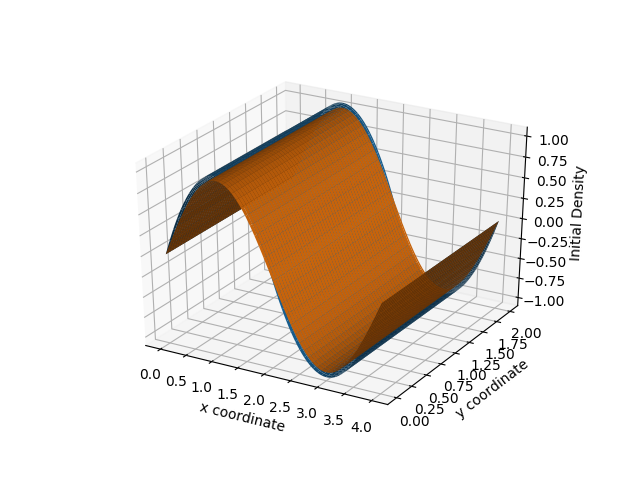

Text(0.5, 0, 'Initial Density')

In [376]:
%matplotlib notebook

rho_0_plot = eva.FEM_field_3d(rho_coeff_init, 3, [xi1,xi2,xi3], T, p, bc) /det

#rho_phys_0_plot =push_forward_V3(rho_0_plot,[xi1,xi2,xi3]) #divide by jacobian determinant
    
#x_m, y_m=np.meshgrid(x,y)
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.plot_surface(x_m.reshape(np1,np2),y_m.reshape(np1,np2),rho_0_plot.reshape(np1,np2))
rho_ex_0=np.empty((np1,np2,np3))
for i1 in range(np1):
    for i2 in range(np2):
        for i3 in range(np3):
            idx=i1,i2,i3
            rho_ex_0[idx] = rho_ini_phys(x_m[idx],y_m[idx],z_m[idx])
          
ax.plot_surface(x_m.reshape(np1,np2),y_m.reshape(np1,np2),rho_ex_0.reshape(np1,np2))
plt.xlabel('x coordinate')
plt.ylabel('y coordinate')
ax.set_zlabel('Initial Density')

In [92]:
#L1error
np.amax(np.abs(rho_ex_0-rho_0_plot))

0.004036846267331612

In [93]:
#fig = plt.figure()
#ax = fig.add_subplot(111, projection='3d')
#ax.plot_wireframe( x_m.reshape(np1,np2),y_m.reshape(np1,np2),np.zeros((np1,np2)), rstride=1)

In [360]:
def density_analytical(dt,ntsteps):
    rho_ex_1=np.empty((np1,np2,np3))
    for i1 in range(np1):
        for i2 in range(np2):
            for i3 in range(np3):
                idx=i1,i2,i3
                xt = x_m[idx] -ntsteps*dt*vx_ini_phys(x_m[idx],y_m[idx],z_m[idx])
                yt = y_m[idx] -ntsteps*dt*vy_ini_phys(x_m[idx],y_m[idx],z_m[idx])
                zt = z_m[idx] -ntsteps*dt*vz_ini_phys(x_m[idx],y_m[idx],z_m[idx])
                rho_ex_1[idx] = rho_ini_phys(xt,yt,zt)
    return rho_ex_1

#### Total Mass $M(t_n)=\int_{V}\sum_{i=1}^{n_x+n_y+n_z}\rho_i(t_n) \Lambda_i^3(x) dV =\sum_{i=1}^{n_x+n_y+n_z}\rho_i(t_n) \int_{V}\Lambda_i^3(x) dV$ 

In [361]:
import scipy
from scipy import integrate
def rhoi_Ai(x,y,rho_coeff):
    global T
    global p
    global bc
    z=0
    z=np.array([z])
    return eva.FEM_field_3d(rho_coeff,3, [[x],[y],z], T, p, bc)[0][0][0]
def integral_x(y,rho_coeff):
    return scipy.integrate.quad(rhoi_Ai, 0, 1,args=(y,rho_coeff))[0]
scipy.integrate.quad(integral_x, 0, 1,args=(rho_coeff))

(-4.996580665241382e-16, 2.5958032749180064e-16)

[array([-0.75, -0.5 , -0.25,  0.  ,  0.25,  0.5 ,  0.75,  1.  ,  1.25,
         1.5 ,  1.75]),
 array([-1.  , -0.75, -0.5 , -0.25,  0.  ,  0.25,  0.5 ,  0.75,  1.  ,
         1.25,  1.5 ,  1.75,  2.  ]),
 array([-0.5,  0. ,  0.5,  1. ,  1.5])]

#### Compute the solution, the error evolution and the mass conservation

In [367]:
%%notify
###Control of Simulations### 
(Nel, bc, p, Nq, el_b, 
 delta, T, t, NbaseN, 
 NbaseD, Lx, Ly, Lz, kind_map,
 args_map, alpha)=Parameters(Nel=[4,4,2],kind_map  = 1)
(proj_glob, der, DIV)=Projectors_ini()
rho_coeff_init=density_ini(rho_ini)
rho_coeff=density_ini(rho_ini)
(np1,np2,np3,xi1,xi2,xi3,x_m,y_m,z_m,det)=Visualization_update()
# Explicit Euler Integration
start_time = time.time()


###Simulation:
Nsteps=1000
DT=[0.25]#[0.05,0.01,0.005,0.001]
L1_Error=[]
L1_Evot=[]
Mass_T=[scipy.integrate.quad(integral_x, 0, 1,args=(rho_coeff))[0]]
Coeff_T=[np.sum(rho_coeff.flatten())]
Semi_Disc_mass=[]
for k in DT:#range(1):
    rho_coeff = rho_coeff_init
    dt=k
    ntsteps=Nsteps
    l1_evo=[]
    for it in range(ntsteps):
        rho_t=eva_rho_t()
        rho_coeff=(rho_coeff+dt*rho_t)
        rho_1_plot=eva.FEM_field_3d(rho_coeff,3, [xi1,xi2,xi3], T, p, bc)/det
        rho_ex_1=density_analytical(dt,it+1)
        l1_error=np.amax(np.abs(rho_ex_1-rho_1_plot))
        l1_evo.append(l1_error)
        Coeff_T.append(np.sum(rho_coeff.flatten()))
        #Mass_T.append(scipy.integrate.quad(integral_x, 0, 1,args=(rho_coeff))[0])
        Semi_Disc_mass.append(np.sum(rho_t.flatten()))
    L1_Evot.append(l1_evo)
    L1_Error.append(l1_error)
    print(l1_error)
    print(np.amax(np.abs(rho_ex_1-rho_1_plot)))
    print("--- %s seconds ---" % (time.time() - start_time))

Parameters update Realized
Projectors Initialized
Density PI3 Projection done
Density PI3 Projection done
Visualization Updated
4.1765787590925546e+28
4.1765787590925546e+28
--- 497.5860598087311 seconds ---


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>


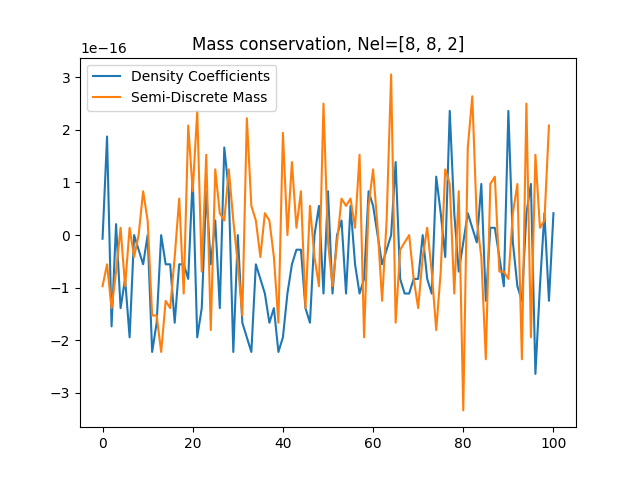

In [340]:
plt.figure()
#plt.plot(Mass_T, label='Total Mass')
plt.plot(Coeff_T, label='Density Coefficients')
plt.plot( Semi_Disc_mass, label='Semi-Discrete Mass')
plt.title('Mass conservation, Nel='+str(Nel))
plt.legend()

<IPython.core.display.Javascript object>


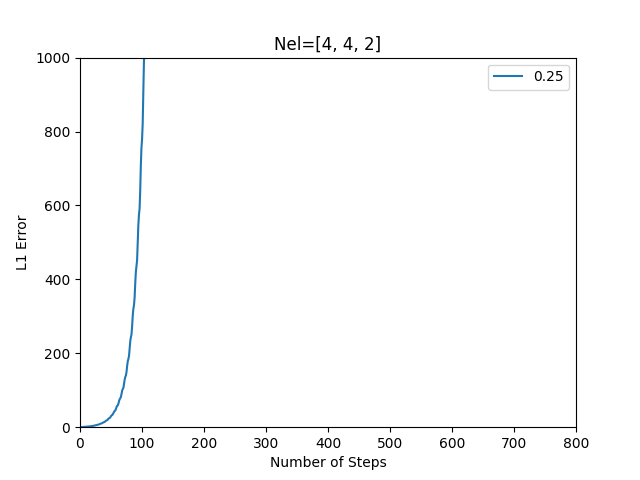

(0, 1000)

In [373]:
plt.figure()
plt.plot(np.linspace(1,1001,1000),L1_Evot[0],label=str(DT[0]))
#plt.plot(np.linspace(1,52,51),L1_Evot[1],label=str(DT[1]))
#plt.plot(np.linspace(1,52,51),L1_Evot[2],label=str(DT[2]))
#plt.plot(np.linspace(1,52,51),L1_Evot[3],label=str(DT[3]))
plt.xlabel('Number of Steps')
plt.ylabel('L1 Error')
plt.title('Nel='+str(Nel))
plt.legend()
plt.xlim(0, 800)
plt.ylim(0,1000)

<IPython.core.display.Javascript object>


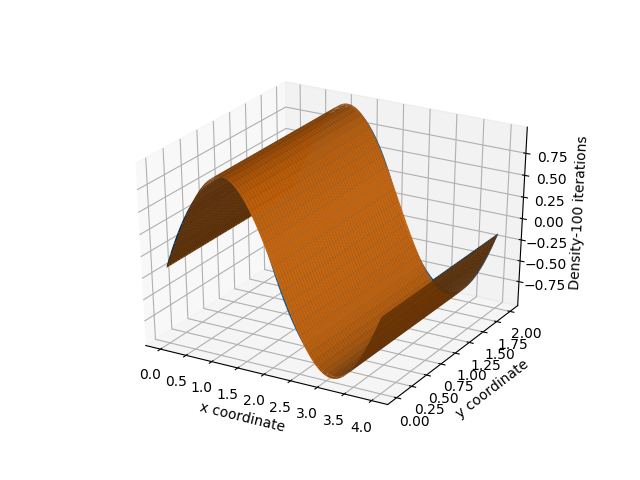

Text(0.5, 0, 'Density-100 iterations')

In [337]:
rho_1_plot=eva.FEM_field_3d(rho_coeff,3, [xi1,xi2,xi3], T, p, bc)/det
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.plot_surface(x_m.reshape(np1,np2),y_m.reshape(np1,np2),rho_1_plot.reshape(np1,np2))
#exact density at time t=ntsteps*dt, translated with a constant velocity field
ntsteps=100
rho_ex_1=density_analytical(DT[0],100)
ax.plot_surface(x_m.reshape(np1,np2),y_m.reshape(np1,np2),rho_ex_1.reshape(np1,np2))
plt.xlabel('x coordinate')
plt.ylabel('y coordinate')
ax.set_zlabel('Density-'+str(ntsteps)+' iterations')

In [338]:
#L1error
np.amax(np.abs(rho_ex_1-rho_1_plot))

0.046581950471436234

In [145]:
#plt.figure()
#plt.plot([0.05,0.01,0.005,0.001],L1_Error,'-o')
#plt.xlabel('Timestep dt')
#plt.ylabel('L1 Error')
#plt.title('Nel='+str(Nel)+', Iterations='+str(Nsteps))